<a href="https://colab.research.google.com/github/Ssurf777/VAE_sample/blob/main/modelnet10_rotation_T_net_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ライブラリインポート

In [1]:
import os
import numpy as np
import random
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader,TensorDataset
from torchvision import transforms, utils

import scipy.spatial.distance
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import pandas as pd

関数定義

In [2]:
import numpy as np
import plotly.graph_objs as go

def read_off(file):
    if 'OFF' != file.readline().strip():
        raise ValueError('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames = []

    def rotate_z(x, y, z, theta):
        w = x + 1j * y
        return np.real(np.exp(1j * theta) * w), np.imag(np.exp(1j * theta) * w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))

    fig = go.Figure(
        data=data,
        layout=go.Layout(
            updatemenus=[dict(
                type='buttons',
                showactive=False,
                y=1,
                x=0.8,
                xanchor='left',
                yanchor='bottom',
                pad=dict(t=45, r=10),
                buttons=[dict(
                    label='Play',
                    method='animate',
                    args=[None, dict(
                        frame=dict(duration=50, redraw=True),
                        transition=dict(duration=0),
                        fromcurrent=True,
                        mode='immediate'
                    )]
                )]
            )],
        ),
        frames=frames
    )
    return fig

def pcshow(xs, ys, zs):
    data = [go.Scatter3d(x=xs, y=ys, z=zs, mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(
        marker=dict(
            size=2,
            line=dict(
                width=2,
                color='DarkSlateGrey'
            )
        ),
        selector=dict(mode='markers')
    )
    fig.show()


内挿サンプリング

In [3]:
# 内挿域サンプリング
class PointSampler(object):
  def __init__(self, output_size):
    assert isinstance(output_size, int)
    self.output_size = output_size

  def triangle_area(self, pt1, pt2, pt3):
    side_a = np.linalg.norm(pt1 - pt2)
    side_b = np.linalg.norm(pt2 - pt3)
    side_c = np.linalg.norm(pt3 - pt1)
    s = 0.5 * (side_a + side_b + side_c)
    return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

  def sample_point(self, pt1, pt2, pt3):
    s, t = sorted([random.random(),random.random()])
    f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
    return (f(0), f(1), f(2))

  def __call__(self,mesh):
    verts, faces = mesh
    verts = np.array(verts)
    areas = np.zeros((len(faces)))

    for i in range(len(areas)):
      areas[i] = (self.triangle_area(verts[faces[i][0]],
                                     verts[faces[i][1]],
                                     verts[faces[i][2]]))
      sampled_faces = (random.choices(faces,
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
      sampled_points = np.zeros((self.output_size,3))
    for i in range(len(sampled_faces)):
      sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                             verts[sampled_faces[i][1]],
                                             verts[sampled_faces[i][2]]))
    return sampled_points

# min-max正規化

In [4]:
class Normalize(object):
  def __call__(self, pointcloud):
    assert len(pointcloud.shape)==2

    norm_pointcloud = pointcloud - pointcloud.min()
    norm_pointcloud /= (pointcloud.max() - pointcloud.min())
    return norm_pointcloud

In [5]:
np.random.seed(42)
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Z軸回転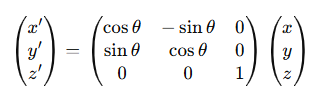

y軸回転
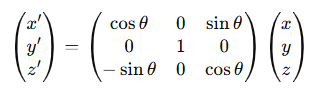

In [6]:
file_names = [f"/content/drive/MyDrive/chair/chair_{i:04d}.off" for i in range(1,10)]

input_data_list = []

for file_name in file_names:
  with open(file_name, 'r') as f:
    verts, faces = read_off(f)

    i,j,k = np.array(faces).T
    x,y,z = np.array(verts).T

    pointcloud = PointSampler(3000)((verts,faces))

    # traindata
    train_x = pointcloud[:,0]
    train_y = pointcloud[:,1]
    train_z = pointcloud[:,2]

    # traindata rotation
    # θをランダムに生成（0から2πの範囲）
    theta = np.random.uniform(0, 2 * np.pi)
    # 回転行列を計算
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    # z軸座標中心に回転
    train_x2 = train_x * cos_theta - train_y * sin_theta
    train_y2 = train_x * sin_theta + train_y * cos_theta
    train_z2 = train_z

    # さらにy軸中心に回転
    train_xr = train_x2 * cos_theta + train_z2 * sin_theta
    train_yr = train_y2
    train_zr = train_x2 * (-1)*sin_theta + train_z2 * cos_theta

    # 正規化
    train_xrn = (train_xr - train_xr.min() )/ (train_xr.max() - train_xr.min())
    train_yrn = (train_yr - train_yr.min() )/ (train_yr.max() - train_yr.min())
    train_zrn = (train_zr - train_zr.min() )/ (train_zr.max() - train_zr.min())

    # data combine
    combined_data = np.concatenate((train_xrn,train_yrn,train_zrn))

    # input data
    input_data_list.append(combined_data)

  input_data = np.stack(input_data_list)
  input_tensor = torch.tensor(input_data, dtype=torch.float32).cuda()
  #input_tensor = torch.tensor(input_data, dtype=torch.float32)
  batch_size = 1
  dataset = TensorDataset(input_tensor)
  data_loader = DataLoader(dataset,batch_size=batch_size,shuffle=False)

In [7]:
input_data.shape

(9, 9000)

形状毎に回転させた

In [8]:
pcshow(train_xrn,train_yrn,train_zrn)

T-NetをVAEのエンコーダー部分に付与

T-Net

In [22]:
class Tnet(nn.Module):
    def __init__(self, n_in_out=3 * 3000):
        super(Tnet, self).__init__()
        self.conv1 = nn.Conv1d(n_in_out, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv3 = nn.Conv1d(128, 1024, kernel_size=1)
        self.linear1 = nn.Linear(1024, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 3**2)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
        self.max_pool = nn.MaxPool1d(kernel_size=num_points)

    def forward(self, x):
        bs = x.shape[0]
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.max_pool(x).view(bs, -1)
        x = self.bn4(F.relu(self.linear1(x)))
        x = self.bn5(F.relu(self.linear2(x)))
        x = self.linear3(x)
        iden = torch.eye(self.dim, requires_grad=True).repeat(bs, 1, 1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x.view(-1, self.dim, self.dim) + iden
        return x

In [30]:
import torch.nn.functional as F
dim=3
n_in_out = 3*3000
n_mid1 = 512
n_mid2 = 256
n_mid3 = 128
n_mid4 = 64
n_mid5 = 32
n_z = 2 # 潜在変数の数

class TNETVAE(nn.Module):
  def __init__(self):
    super(TNETVAE, self).__init__()

    # Encoder
    self.encoder = Tnet(n_in_out=3 * 3000)
    self.enc_mu = nn.Linear(3**2, n_z)
    self.enc_logvar = nn.Linear(3**2, n_z)

    # Decoder
    self.dec1 = nn.Linear(n_z, n_mid5)
    self.dec2 = nn.Linear(n_mid5, n_mid4)
    self.dec3 = nn.Linear(n_mid4, n_mid3)
    self.dec4 = nn.Linear(n_mid3, n_mid2)
    self.dec5 = nn.Linear(n_mid2, n_mid1)
    self.dec_out = nn.Linear(n_mid1, n_in_out)

    # weight initial
    self._init_weights()
  def forward(self, x):
    z = self.encode(x)
    y = self.decode(z)
    return y

  def encode(self, x):
    '''x = x.view(-1, n_in_out)
    x = F.relu(self.enc1(x))
    x = F.relu(self.enc2(x))
    x = F.relu(self.enc3(x))
    x = F.relu(self.enc4(x))
    x = F.relu(self.enc5(x))'''
    mu = self.enc_mu(x)
    logvar = self.enc_logvar(x)
    std = torch.exp(0.5 * logvar) # sigma
    eps = torch.randn_like(std) # 正規分布に従う乱数
    z = mu +std * eps # 潜在変数
    self.mu = mu
    self.logvar = logvar
    return mu, logvar

  def decode(self,z):
    z_sample = z[0]
    x = F.relu(self.dec1(z_sample))
    x = F.relu(self.dec2(x))
    x = F.relu(self.dec3(x))
    x = F.relu(self.dec4(x))
    x = F.relu(self.dec5(x))
    x = torch.sigmoid(self.dec_out(x))
    return x

  def loss(self, y, x):
    x = x.view(-1, n_in_out)

    rec_loss = F.mse_loss(y, x, reduction="sum") # 再構成誤差をMSEで計算
    reg_loss = 0.5 * torch.sum(self.mu**2 + torch.exp(self.logvar) - self.logvar -1 ) # 正則化項
    return (rec_loss, reg_loss)

  def _init_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
          nn.init.zeros_(m.bias)

vae = TNETVAE()
print(vae)
vae.cuda()

TNETVAE(
  (encoder): Tnet(
    (conv1): Conv1d(9000, 64, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
    (linear1): Linear(in_features=1024, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=256, bias=True)
    (linear3): Linear(in_features=256, out_features=9, bias=True)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool): MaxPool1d(kernel_size=3000, stride=3000, padding=0, dilation=1, ceil_mode=False)
  )
  (enc_mu): Linear(in_fea

TNETVAE(
  (encoder): Tnet(
    (conv1): Conv1d(9000, 64, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
    (linear1): Linear(in_features=1024, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=256, bias=True)
    (linear3): Linear(in_features=256, out_features=9, bias=True)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool): MaxPool1d(kernel_size=3000, stride=3000, padding=0, dilation=1, ceil_mode=False)
  )
  (enc_mu): Linear(in_fea

In [31]:
# training setting
eta = 0.0001
epochs = 700
batch_size = 1
interval = 10

In [32]:
from torch import optim

optimizer = optim.Adam(vae.parameters(),lr=eta)

rec_error_record = []
reg_error_record = []
total_error_record = []

for i in range(epochs):
  vae.train()
  loss_rec = 0
  loss_reg = 0
  loss_total = 0

  for j, (x,) in enumerate(data_loader):
    x = x.cuda()
    print(x.shape)
    y = vae(x)
    lrec, lreg = vae.loss(y,x)
    loss = lrec + lreg
    loss_rec += lrec.item()
    loss_reg += lreg.item()
    loss_total += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  loss_rec /= j+1
  loss_reg /= j+1
  loss_total/= j+1
  rec_error_record.append(loss_rec)
  reg_error_record.append(loss_reg)
  total_error_record.append(loss_total)
  if i%interval ==0:
    print(f"Epoch:{i} Loss_Rec:{loss_rec} Loss_Reg:{loss_reg} Loss_Total:{loss_total}")

torch.Size([1, 9000])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x9000 and 9x2)

PointNet

In [10]:
class PointNetBackbone(nn.Module):
    def __init__(self, num_points=3000, num_global_feats=1024, local_feat=True):
        super(PointNetBackbone, self).__init__()
        self.num_points = num_points
        self.num_global_feats = num_global_feats
        self.local_feat = local_feat
        self.tnet1 = Tnet(dim=3, num_points=num_points)
        self.tnet2 = Tnet(dim=64, num_points=num_points)
        self.conv1 = nn.Conv1d(3, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=1)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=1)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv5 = nn.Conv1d(128, self.num_global_feats, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(self.num_global_feats)
        self.max_pool = nn.MaxPool1d(kernel_size=num_points, return_indices=True)

    def forward(self, x):
        bs = x.shape[0]
        A_input = self.tnet1(x)
        x = torch.bmm(x.transpose(2, 1), A_input).transpose(2, 1)
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        A_feat = self.tnet2(x)
        x = torch.bmm(x.transpose(2, 1), A_feat).transpose(2, 1)
        local_features = x.clone()
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))
        global_features, critical_indexes = self.max_pool(x)
        global_features = global_features.view(bs, -1)
        critical_indexes = critical_indexes.view(bs, -1)
        if self.local_feat:
            features = torch.cat((local_features, global_features.unsqueeze(-1).repeat(1, 1, self.num_points)), dim=1)
            return features, critical_indexes, A_feat
        else:
            return global_features, critical_indexes, A_feat


VAE(PointNet - MLP)

In [11]:
class PointNetVAE(nn.Module):
    def __init__(self, num_points=3000, latent_dim=2):
        super(PointNetVAE, self).__init__()
        self.encoder = PointNetBackbone(num_points=num_points, num_global_feats=1024, local_feat=False)
        self.fc_mu = nn.Linear(1024, latent_dim)
        self.fc_logvar = nn.Linear(1024, latent_dim)

        n_in_out = 3 * num_points
        n_mid1 = 512
        n_mid2 = 256
        n_mid3 = 128
        n_mid4 = 64
        n_mid5 = 32

        self.dec1 = nn.Linear(latent_dim, n_mid5)
        self.dec2 = nn.Linear(n_mid5, n_mid4)
        self.dec3 = nn.Linear(n_mid4, n_mid3)
        self.dec4 = nn.Linear(n_mid3, n_mid2)
        self.dec5 = nn.Linear(n_mid2, n_mid1)
        self.dec_out = nn.Linear(n_mid1, n_in_out)

    def encode(self, x):
        x, _, _ = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x))
        x = self.dec_out(x)
        x = x.view(-1, 3, 3000)  # デコードされた点群データの形状に変換
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, logvar

# 損失関数の定義
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld_loss


In [12]:
# 学習ループの定義
def train_vae(model, data_loader, optimizer, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for x in data_loader:
            x = x.to(device)
            optimizer.zero_grad()
            recon_x, mu, logvar = model(x)
            loss = vae_loss(recon_x, x, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(data_loader.dataset)}")


In [14]:
import torch
from torch.utils.data import DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_points = 3000
latent_dim = 2
vae = PointNetVAE(num_points=num_points, latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# VAEの学習
train_vae(vae, data_loader, optimizer)


AttributeError: 'list' object has no attribute 'to'

PointNetを入れないとどうなるか？

In [ ]:
# training setting
eta = 0.0001
epochs = 700
batch_size = 1
interval = 10

In [ ]:
import torch.nn.functional as F

n_in_out = 3*3000
n_mid1 = 512
n_mid2 = 256
n_mid3 = 128
n_mid4 = 64
n_mid5 = 32
n_z = 2 # 潜在変数の数

class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()

    # Encoder
    self.enc1 = nn.Linear(n_in_out, n_mid1)
    self.enc2 = nn.Linear(n_mid1, n_mid2)
    self.enc3 = nn.Linear(n_mid2, n_mid3)
    self.enc4 = nn.Linear(n_mid3, n_mid4)
    self.enc5 = nn.Linear(n_mid4, n_mid5)
    self.enc_mu = nn.Linear(n_mid5, n_z)
    self.enc_logvar = nn.Linear(n_mid5, n_z)

    # Decoder
    self.dec1 = nn.Linear(n_z, n_mid5)
    self.dec2 = nn.Linear(n_mid5, n_mid4)
    self.dec3 = nn.Linear(n_mid4, n_mid3)
    self.dec4 = nn.Linear(n_mid3, n_mid2)
    self.dec5 = nn.Linear(n_mid2, n_mid1)
    self.dec_out = nn.Linear(n_mid1, n_in_out)

    # weight initial
    self._init_weights()
  def forward(self, x):
    z = self.encode(x)
    y = self.decode(z)
    return y

  def encode(self, x):
    x = x.view(-1, n_in_out)
    x = F.relu(self.enc1(x))
    x = F.relu(self.enc2(x))
    x = F.relu(self.enc3(x))
    x = F.relu(self.enc4(x))
    x = F.relu(self.enc5(x))
    mu = self.enc_mu(x)
    logvar = self.enc_logvar(x)
    std = torch.exp(0.5 * logvar) # sigma
    eps = torch.randn_like(std) # 正規分布に従う乱数
    z = mu +std * eps # 潜在変数
    self.mu = mu
    self.logvar = logvar
    return mu, logvar

  def decode(self,z):
    z_sample = z[0]
    x = F.relu(self.dec1(z_sample))
    x = F.relu(self.dec2(x))
    x = F.relu(self.dec3(x))
    x = F.relu(self.dec4(x))
    x = F.relu(self.dec5(x))
    x = torch.sigmoid(self.dec_out(x))
    return x

  def loss(self, y, x):
    x = x.view(-1, n_in_out)

    rec_loss = F.mse_loss(y, x, reduction="sum") # 再構成誤差をMSEで計算
    reg_loss = 0.5 * torch.sum(self.mu**2 + torch.exp(self.logvar) - self.logvar -1 ) # 正則化項
    return (rec_loss, reg_loss)

  def _init_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
          nn.init.zeros_(m.bias)

vae = VAE()
print(vae)
vae.cuda()




VAE(
  (enc1): Linear(in_features=9000, out_features=512, bias=True)
  (enc2): Linear(in_features=512, out_features=256, bias=True)
  (enc3): Linear(in_features=256, out_features=128, bias=True)
  (enc4): Linear(in_features=128, out_features=64, bias=True)
  (enc5): Linear(in_features=64, out_features=32, bias=True)
  (enc_mu): Linear(in_features=32, out_features=2, bias=True)
  (enc_logvar): Linear(in_features=32, out_features=2, bias=True)
  (dec1): Linear(in_features=2, out_features=32, bias=True)
  (dec2): Linear(in_features=32, out_features=64, bias=True)
  (dec3): Linear(in_features=64, out_features=128, bias=True)
  (dec4): Linear(in_features=128, out_features=256, bias=True)
  (dec5): Linear(in_features=256, out_features=512, bias=True)
  (dec_out): Linear(in_features=512, out_features=9000, bias=True)
)


VAE(
  (enc1): Linear(in_features=9000, out_features=512, bias=True)
  (enc2): Linear(in_features=512, out_features=256, bias=True)
  (enc3): Linear(in_features=256, out_features=128, bias=True)
  (enc4): Linear(in_features=128, out_features=64, bias=True)
  (enc5): Linear(in_features=64, out_features=32, bias=True)
  (enc_mu): Linear(in_features=32, out_features=2, bias=True)
  (enc_logvar): Linear(in_features=32, out_features=2, bias=True)
  (dec1): Linear(in_features=2, out_features=32, bias=True)
  (dec2): Linear(in_features=32, out_features=64, bias=True)
  (dec3): Linear(in_features=64, out_features=128, bias=True)
  (dec4): Linear(in_features=128, out_features=256, bias=True)
  (dec5): Linear(in_features=256, out_features=512, bias=True)
  (dec_out): Linear(in_features=512, out_features=9000, bias=True)
)

In [ ]:
from torch import optim

optimizer = optim.Adam(vae.parameters(),lr=eta)

rec_error_record = []
reg_error_record = []
total_error_record = []

for i in range(epochs):
  vae.train()
  loss_rec = 0
  loss_reg = 0
  loss_total = 0

  for j, (x,) in enumerate(data_loader):
    x = x.cuda()
    y = vae(x)
    lrec, lreg = vae.loss(y,x)
    loss = lrec + lreg
    loss_rec += lrec.item()
    loss_reg += lreg.item()
    loss_total += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  loss_rec /= j+1
  loss_reg /= j+1
  loss_total/= j+1
  rec_error_record.append(loss_rec)
  reg_error_record.append(loss_reg)
  total_error_record.append(loss_total)
  if i%interval ==0:
    print(f"Epoch:{i} Loss_Rec:{loss_rec} Loss_Reg:{loss_reg} Loss_Total:{loss_total}")

Epoch:0 Loss_Rec:577.0863240559896 Loss_Reg:0.21383583545684814 Loss_Total:577.3001641167534
Epoch:10 Loss_Rec:529.2709147135416 Loss_Reg:3.017321056789822 Loss_Total:532.2882351345486
Epoch:20 Loss_Rec:511.85815090603296 Loss_Reg:1.9469459056854248 Loss_Total:513.8051045735677
Epoch:30 Loss_Rec:510.18296305338544 Loss_Reg:1.0842793252733018 Loss_Total:511.2672424316406
Epoch:40 Loss_Rec:488.2991434733073 Loss_Reg:1.6903961433304682 Loss_Total:489.9895426432292
Epoch:50 Loss_Rec:437.0784606933594 Loss_Reg:2.507811095979479 Loss_Total:439.5862681070964
Epoch:60 Loss_Rec:434.3139834933811 Loss_Reg:2.462563309404585 Loss_Total:436.77655029296875
Epoch:70 Loss_Rec:426.29833645290796 Loss_Reg:2.1126820378833346 Loss_Total:428.41102430555554
Epoch:80 Loss_Rec:418.229738023546 Loss_Reg:2.3906796971956887 Loss_Total:420.62042066786023
Epoch:90 Loss_Rec:378.0042436387804 Loss_Reg:3.841386225488451 Loss_Total:381.8456276787652
Epoch:100 Loss_Rec:368.9792955186632 Loss_Reg:3.1259817944632635 Loss

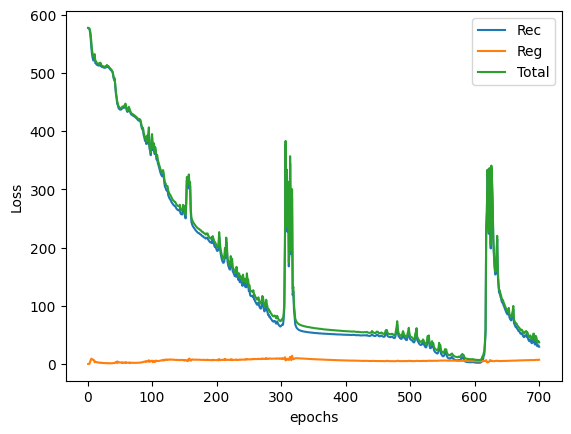

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(rec_error_record)+1),rec_error_record,label="Rec")
plt.plot(range(1, len(reg_error_record)+1),reg_error_record,label="Reg")
plt.plot(range(1, len(total_error_record)+1),total_error_record,label="Total")
plt.legend()

plt.xlabel("epochs")
plt.ylabel("Loss")
plt.show()


# 再構成して可視化する

In [ ]:
vae.eval()
with torch.no_grad():
  reconstructions = []
  for batch in data_loader:
    batch = batch[0]
    recon_batch = vae(batch)
    reconstructions.append(recon_batch.cpu().numpy())

reconstructed_data = recon_batch.cpu().detach().numpy().reshape(-1)

reconstructed_x = reconstructed_data[:3000]
reconstructed_y = reconstructed_data[3000:6000]
reconstructed_z = reconstructed_data[6000:9000]


In [ ]:
print("Original")
pcshow(train_xrn,train_yrn,train_zrn)
print("再構成")
pcshow(reconstructed_x,reconstructed_y,reconstructed_z)

Original


再構成


In [ ]:
# 潜在変数を振って可視化する
z_mod = torch.tensor([[-1.0,0.95]],device='cuda:0')
recon_batch2 = vae.decode(z_mod)
reconst2= recon_batch2.cpu().detach().numpy().reshape(-1)

reconst2_x = reconst2[:3000]
reconst2_y = reconst2[3000:6000]
reconst2_z = reconst2[6000:9000]
pcshow(reconst2_x,reconst2_y,reconst2_z)

In [ ]:
import torch
'''
# ループして潜在変数を変化させ、再構築と可視化を行う
for z1 in np.arange(-1.0, 1.5, 0.5):
    for z2 in np.arange(-1.0, 1.5, 0.5):
        z_mod = torch.tensor([[z1, z2]], device='cuda:0', dtype=torch.float32)
        recon_batch2 = vae.decode(z_mod)
        reconst2 = recon_batch2.cpu().detach().numpy().reshape(-1)

        reconst2_x = reconst2[:3000]
        reconst2_y = reconst2[3000:6000]
        reconst2_z = reconst2[6000:9000]

        print(f"Visualizing for z1={z1}, z2={z2}")
        pcshow(reconst2_x, reconst2_y, reconst2_z)
'''

In [ ]:
def plot_point_cloud(xs, ys, zs, title="Point Cloud"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs, ys, zs, s=1)
    ax.set_title(title)
    plt.show()


In [ ]:
# ループして潜在変数を変化させ、再構築と可視化を行う
for z1 in np.arange(-1.0, 1.2, 0.2):
    for z2 in np.arange(-1.0, 1.2, 0.2):
        z_mod = torch.tensor([[z1, z2]], device='cuda:0', dtype=torch.float32)  # データ型をfloat32に設定
        recon_batch2 = vae.decode(z_mod)
        reconst2 = recon_batch2.cpu().detach().numpy().reshape(-1)

        reconst2_x = reconst2[:3000]
        reconst2_y = reconst2[3000:6000]
        reconst2_z = reconst2[6000:9000]

        title = f"Point Cloud for z1={z1}, z2={z2}"
        plot_point_cloud(reconst2_x, reconst2_y, reconst2_z, title)
